In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from yahoo_historical import Fetcher


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [159]:
ticker = 'AAPL'
dstart = [2019,1,1]


dataset = Fetcher(ticker, dstart).getHistorical()	
#df = df[['Date','Close']]
dataset.Date = pd.to_datetime(dataset.Date)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.505024,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.669640,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.149662,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.069202,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.756794,164101200


In [160]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
524,2021-02-01,133.750000,135.380005,130.929993,134.139999,133.939850,106239800
525,2021-02-02,135.729996,136.309998,134.610001,134.990005,134.788589,83305400
526,2021-02-03,135.759995,135.770004,133.610001,133.940002,133.740158,89880900
527,2021-02-04,136.300003,137.399994,134.589996,137.389999,137.184998,84183100
528,2021-02-05,137.350006,137.419998,135.860001,136.759995,136.759995,75524000


In [161]:
dataset.shape

(529, 7)

In [162]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [163]:
timestamp = dataset.Date

In [164]:
target = dataset.Close

In [165]:
#remove Time and Name as they are not useful for LSTM
#move Clsoe to last column to make data splitting easier
dataset.drop(['Date','Close','Adj Close'], axis=1, inplace=True)
dataset['Close'] = target

In [166]:
dataset.head()

,Open,High,Low,Volume,Close
0,38.722500,39.712502,38.557499,148158800,39.480000
1,35.994999,36.430000,35.500000,365248800,35.547501
2,36.132500,37.137501,35.950001,234428400,37.064999
3,37.174999,37.207500,36.474998,219111200,36.982498
4,37.389999,37.955002,37.130001,164101200,37.687500


In [167]:
dataset.shape

(529, 5)

In [168]:
dataset['chg'] = dataset.Close-dataset.Close.shift(1)
dataset.head()

,Open,High,Low,Volume,Close,chg
0,38.722500,39.712502,38.557499,148158800,39.480000,NaN
1,35.994999,36.430000,35.500000,365248800,35.547501,-3.932499
2,36.132500,37.137501,35.950001,234428400,37.064999,1.517498
3,37.174999,37.207500,36.474998,219111200,36.982498,-0.082501
4,37.389999,37.955002,37.130001,164101200,37.687500,0.705002


In [169]:
dataset.drop('Close', axis=1, inplace=True)


In [170]:
dataset = dataset.iloc[1:,:]

In [172]:
dataset.head()

,Open,High,Low,Volume,chg
1,35.994999,36.430000,35.500000,365248800,-3.932499
2,36.132500,37.137501,35.950001,234428400,1.517498
3,37.174999,37.207500,36.474998,219111200,-0.082501
4,37.389999,37.955002,37.130001,164101200,0.705002
5,37.822498,38.632500,37.407501,180396400,0.639999


In [171]:
dataset.shape

(528, 5)

In [173]:
values = dataset.values

In [174]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [175]:
scaled

array([[0.        , 0.        , 0.        , 0.83841098, 0.31993681],
       [0.00127783, 0.00651115, 0.00425051, 0.49544354, 0.5846283 ],
       [0.01096603, 0.00715535, 0.00920939, 0.45528696, 0.50692071],
       ...,
       [0.92714083, 0.91422794, 0.92670261, 0.11648824, 0.45993178],
       [0.93215926, 0.92922877, 0.9359592 , 0.10155051, 0.67848451],
       [0.9419172 , 0.92941286, 0.94795509, 0.07884924, 0.48032999]])

In [176]:
# specify the number of lag hours
n_hours = 3
n_features = 5

In [177]:
# frame as supervised learning
reframed0 = series_to_supervised(values, n_hours, 1)
print(reframed0.shape)

(525, 20)


In [178]:
reframed0.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,35.994999,36.430000,35.500000,365248800.0,-3.932499,36.132500,37.137501,35.950001,234428400.0,1.517498,37.174999,37.207500,36.474998,219111200.0,-0.082501,37.389999,37.955002,37.130001,164101200.0,0.705002
4,36.132500,37.137501,35.950001,234428400.0,1.517498,37.174999,37.207500,36.474998,219111200.0,-0.082501,37.389999,37.955002,37.130001,164101200.0,0.705002,37.822498,38.632500,37.407501,180396400.0,0.639999
5,37.174999,37.207500,36.474998,219111200.0,-0.082501,37.389999,37.955002,37.130001,164101200.0,0.705002,37.822498,38.632500,37.407501,180396400.0,0.639999,38.125000,38.492500,37.715000,143122800.0,0.122502
6,37.389999,37.955002,37.130001,164101200.0,0.705002,37.822498,38.632500,37.407501,180396400.0,0.639999,38.125000,38.492500,37.715000,143122800.0,0.122502,38.220001,38.424999,37.877499,108092800.0,-0.377503
7,37.822498,38.632500,37.407501,180396400.0,0.639999,38.125000,38.492500,37.715000,143122800.0,0.122502,38.220001,38.424999,37.877499,108092800.0,-0.377503,37.712502,37.817501,37.305000,129756800.0,-0.572498


In [179]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(525, 20)


In [180]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.000000,0.000000,0.000000,0.838411,0.319937,0.001278,0.006511,0.004251,0.495444,0.584628,0.010966,0.007155,0.009209,0.455287,0.506921,0.012964,0.014035,0.015396,0.311069,0.545168
4,0.001278,0.006511,0.004251,0.495444,0.584628,0.010966,0.007155,0.009209,0.455287,0.506921,0.012964,0.014035,0.015396,0.311069,0.545168,0.016983,0.020270,0.018017,0.353790,0.542011
5,0.010966,0.007155,0.009209,0.455287,0.506921,0.012964,0.014035,0.015396,0.311069,0.545168,0.016983,0.020270,0.018017,0.353790,0.542011,0.019795,0.018981,0.020922,0.256071,0.516877
6,0.012964,0.014035,0.015396,0.311069,0.545168,0.016983,0.020270,0.018017,0.353790,0.542011,0.019795,0.018981,0.020922,0.256071,0.516877,0.020677,0.018360,0.022457,0.164234,0.492593
7,0.016983,0.020270,0.018017,0.353790,0.542011,0.019795,0.018981,0.020922,0.256071,0.516877,0.020677,0.018360,0.022457,0.164234,0.492593,0.015961,0.012769,0.017049,0.221030,0.483123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.998420,0.992730,0.990932,0.250096,0.457503,0.962084,0.971471,0.955889,0.254755,0.269548,0.927791,0.923155,0.894588,0.345359,0.261778,0.908461,0.910639,0.901388,0.159376,0.616804
524,0.962084,0.971471,0.955889,0.254755,0.269548,0.927791,0.923155,0.894588,0.345359,0.261778,0.908461,0.910639,0.901388,0.159376,0.616804,0.926862,0.919198,0.936148,0.099249,0.552210
525,0.927791,0.923155,0.894588,0.345359,0.261778,0.908461,0.910639,0.901388,0.159376,0.616804,0.926862,0.919198,0.936148,0.099249,0.552210,0.927141,0.914228,0.926703,0.116488,0.459932
526,0.908461,0.910639,0.901388,0.159376,0.616804,0.926862,0.919198,0.936148,0.099249,0.552210,0.927141,0.914228,0.926703,0.116488,0.459932,0.932159,0.929229,0.935959,0.101551,0.678485


In [181]:
reframed.shape

(525, 20)

In [182]:
#pd.DataFrame(scaled).head(10)

In [183]:
# split into train and test sets
values = reframed.values
train = values[:400, :]
val = values[400:450, :]
test = values[450:,:]

In [184]:
arr=[1,2,3,4]
print(arr[0:2])
print(arr[2:4])

[1, 2]
[3, 4]


In [185]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
val_X, val_y = val[:, :n_obs], val[:,-1]
test_X, test_y = test[:, :n_obs], test[:, -1]

In [186]:
print(train_X.shape, train_y.shape, val_X.shape, test_X.shape)

(400, 15) (400,) (50, 15) (75, 15)


In [187]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)


(400, 3, 5) (400,) (50, 3, 5) (50,) (75, 3, 5) (75,)


Epoch 1/100
6/6 - 1s - loss: 0.3941 - val_loss: 0.2737
Epoch 2/100
6/6 - 0s - loss: 0.2858 - val_loss: 0.1521
Epoch 3/100
6/6 - 0s - loss: 0.1818 - val_loss: 0.1860
Epoch 4/100
6/6 - 0s - loss: 0.1236 - val_loss: 0.3339
Epoch 5/100
6/6 - 0s - loss: 0.1078 - val_loss: 0.3569
Epoch 6/100
6/6 - 0s - loss: 0.0926 - val_loss: 0.2914
Epoch 7/100
6/6 - 0s - loss: 0.0781 - val_loss: 0.2159
Epoch 8/100
6/6 - 0s - loss: 0.0776 - val_loss: 0.1834
Epoch 9/100
6/6 - 0s - loss: 0.0785 - val_loss: 0.1785
Epoch 10/100
6/6 - 0s - loss: 0.0730 - val_loss: 0.1807
Epoch 11/100
6/6 - 0s - loss: 0.0673 - val_loss: 0.1761
Epoch 12/100
6/6 - 0s - loss: 0.0625 - val_loss: 0.1631
Epoch 13/100
6/6 - 0s - loss: 0.0592 - val_loss: 0.1496
Epoch 14/100
6/6 - 0s - loss: 0.0577 - val_loss: 0.1434
Epoch 15/100
6/6 - 0s - loss: 0.0562 - val_loss: 0.1414
Epoch 16/100
6/6 - 0s - loss: 0.0545 - val_loss: 0.1396
Epoch 17/100
6/6 - 0s - loss: 0.0536 - val_loss: 0.1382
Epoch 18/100
6/6 - 0s - loss: 0.0532 - val_loss: 0.1376
E

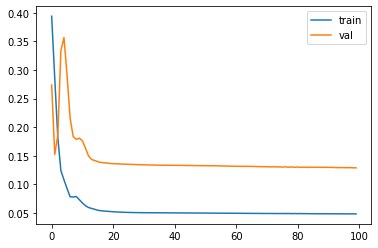

In [190]:
# design network
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))
#model.add(LSTM(50, return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(50))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [191]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_X.shape

(75, 15)

In [192]:
reframed.iloc[:, -n_features:-1].columns

Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'], dtype='object')

In [193]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -n_features:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [194]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -n_features:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
import numpy as np
mape = np.mean(100*abs(inv_y-inv_yhat)/inv_y)
smape = np.mean(200*abs(inv_y-inv_yhat)/(inv_y+inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 2.596
Test MAPE: -1.294


In [195]:
inv_y

array([ 1.529999, -0.639999, -1.120003, -0.709999,  0.010002,  1.549995,
       -5.400001,  4.120003, -6.459999, -0.090004,  1.670005,  4.509995,
        4.080002, -0.339997, -2.370002, -0.349999,  3.519997, -0.279999,
        0.050003,  1.040001, -0.910004, -1.36    ,  0.61    , -1.300003,
       -3.489998,  1.32    ,  0.860001,  0.559997,  2.460007,  3.669998,
        0.360001, -0.14    , -0.690002,  1.5     ,  0.629997, -2.599998,
        1.459999, -0.829994, -0.630005,  6.099998, -0.069999,  0.889999,
       -2.039993,  1.569992,  3.650009, -0.919998,  1.009994,  4.720001,
       -1.820007, -1.149994, -1.029999, -3.279998,  1.599991, -4.409997,
        4.32    ,  1.130005, -3.070007, -0.179993,  2.089996, -1.979995,
       -1.770005,  0.690003,  4.199997,  4.839996,  2.200012,  3.849991,
        0.240006, -1.100006, -4.970002, -5.129989,  2.179992,  0.850006,
       -1.050003,  3.449997, -0.630004])

In [196]:
inv_yhat

array([-0.23477424, -0.17747901, -0.16356189,  0.0674022 , -0.10272419,
       -0.00170355,  0.14978322,  0.01084763,  0.13602441, -0.27688335,
       -0.18751554, -0.53583325,  0.54345124,  0.85449401,  0.70382705,
        0.3366077 , -0.11012211, -0.04482577,  0.23177888,  0.29253068,
        0.1247459 ,  0.1082049 , -0.00263259, -0.04756133, -0.04530931,
       -0.00459497, -0.12430063, -0.16626432,  0.15746464,  0.62025804,
        0.67364751,  0.36100194,  0.29369166,  0.0542018 ,  0.13946565,
        0.20338378,  0.20345005,  0.0082213 , -0.10286532,  0.10312159,
        0.49549485,  0.48095182,  0.42365353,  0.26540211,  0.06705243,
        0.11106687,  0.24309298,  0.03979868,  0.45764862,  0.53931537,
        0.12394082, -0.26745493, -0.12742401, -0.2067872 , -0.27311198,
        0.06150154, -0.0261432 ,  0.29911983, -0.11621913, -0.09886077,
        0.11222785,  0.05251554, -0.19056774,  0.20909053,  0.75733924,
        0.85028328,  0.8476729 ,  0.3812284 ,  0.21688118, -0.20

In [197]:
inv_yhat.shape

(75,)

In [198]:
dataset['Date'] = timestamp
dataset.head()

,Open,High,Low,Volume,chg,Date
1,35.994999,36.430000,35.500000,365248800,-3.932499,2019-01-03
2,36.132500,37.137501,35.950001,234428400,1.517498,2019-01-04
3,37.174999,37.207500,36.474998,219111200,-0.082501,2019-01-07
4,37.389999,37.955002,37.130001,164101200,0.705002,2019-01-08
5,37.822498,38.632500,37.407501,180396400,0.639999,2019-01-09


In [199]:
tr = dataset.iloc[:450,:]
te = dataset.iloc[450:,]

In [200]:
print(tr.shape)
print(te.shape)

(450, 6)
(78, 6)


In [201]:
te.Date[4:].head()

455   2020-10-21
456   2020-10-22
457   2020-10-23
458   2020-10-26
459   2020-10-27
Name: Date, dtype: datetime64[ns]

In [202]:
te.Date.head()

451   2020-10-15
452   2020-10-16
453   2020-10-19
454   2020-10-20
455   2020-10-21
Name: Date, dtype: datetime64[ns]

In [203]:
te.Date.tail()

524   2021-02-01
525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
Name: Date, dtype: datetime64[ns]

In [204]:
from pandas.tseries.offsets import BDay
dates = te.Date[4:]
dates = dates.append(te.Date.tail(1) + BDay(1))
dates.tail()

525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
528   2021-02-08
Name: Date, dtype: datetime64[ns]

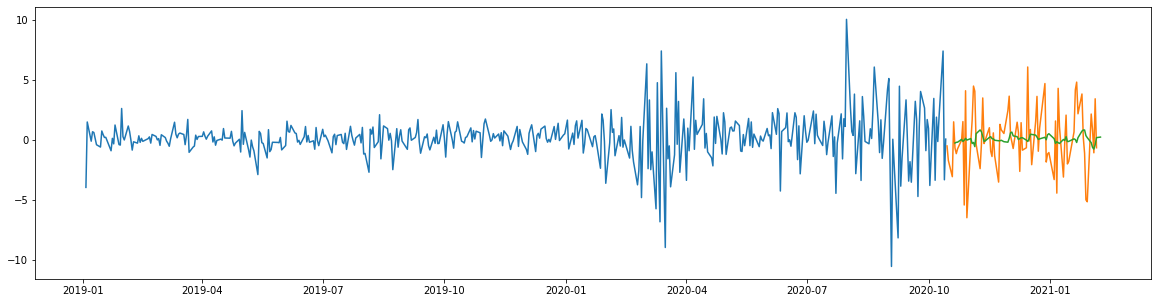

In [206]:
plt.figure(figsize=(20,5))
plt.plot(tr.Date, tr.chg)
plt.plot(te.Date, te.chg)
plt.plot(dates, inv_yhat)

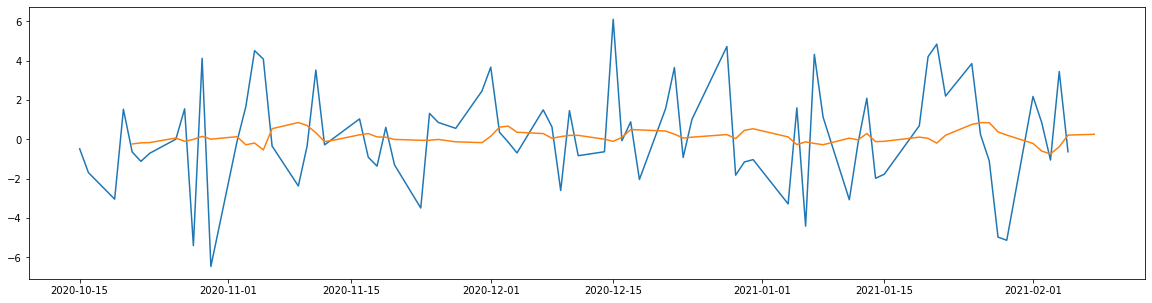

In [208]:
plt.figure(figsize=(20,5))
plt.plot(te.Date, te.chg)
plt.plot(dates, inv_yhat)

In [209]:
df_pred = pd.DataFrame(dates, columns = ['Date']).reset_index(drop=True)
df_pred['pred'] = inv_yhat
df_pred.head()

,Date,pred
0,2020-10-21,-0.234774
1,2020-10-22,-0.177479
2,2020-10-23,-0.163562
3,2020-10-26,0.067402
4,2020-10-27,-0.102724


In [214]:
merged_data = te.merge(df_pred, on = 'Date')

In [215]:
merged_data

,Open,High,Low,Volume,chg,Date,pred
0,116.669998,118.709999,116.449997,89946000,-0.639999,2020-10-21,-0.234774
1,117.449997,118.040001,114.589996,101988000,-1.120003,2020-10-22,-0.177479
2,116.389999,116.550003,114.279999,82572600,-0.709999,2020-10-23,-0.163562
3,114.010002,116.550003,112.879997,111850700,0.010002,2020-10-26,0.067402
4,115.489998,117.279999,114.540001,92276800,1.549995,2020-10-27,-0.102724
...,...,...,...,...,...,...,...
69,133.750000,135.380005,130.929993,106239800,2.179992,2021-02-01,-0.207676
70,135.729996,136.309998,134.610001,83305400,0.850006,2021-02-02,-0.595427
71,135.759995,135.770004,133.610001,89880900,-1.050003,2021-02-03,-0.740379
72,136.300003,137.399994,134.589996,84183100,3.449997,2021-02-04,-0.377243


In [216]:
merged_data['dir'] = merged_data['chg']>0
merged_data['dir'] =  merged_data['dir'].astype(int)
merged_data.head()

,Open,High,Low,Volume,chg,Date,pred,dir
0,116.669998,118.709999,116.449997,89946000,-0.639999,2020-10-21,-0.234774,0
1,117.449997,118.040001,114.589996,101988000,-1.120003,2020-10-22,-0.177479,0
2,116.389999,116.550003,114.279999,82572600,-0.709999,2020-10-23,-0.163562,0
3,114.010002,116.550003,112.879997,111850700,0.010002,2020-10-26,0.067402,1
4,115.489998,117.279999,114.540001,92276800,1.549995,2020-10-27,-0.102724,1


In [217]:

merged_data['dir_pred'] = merged_data['pred']>0
merged_data['dir_pred'] =  merged_data['dir_pred'].astype(int)
merged_data.head(20)

,Open,High,Low,Volume,chg,Date,pred,dir,dir_pred
0,116.669998,118.709999,116.449997,89946000,-0.639999,2020-10-21,-0.234774,0,0
1,117.449997,118.040001,114.589996,101988000,-1.120003,2020-10-22,-0.177479,0,0
2,116.389999,116.550003,114.279999,82572600,-0.709999,2020-10-23,-0.163562,0,0
3,114.010002,116.550003,112.879997,111850700,0.010002,2020-10-26,0.067402,1,1
4,115.489998,117.279999,114.540001,92276800,1.549995,2020-10-27,-0.102724,1,0
5,115.050003,115.430000,111.099998,143937800,-5.400001,2020-10-28,-0.001704,0,0
6,112.370003,116.930000,112.199997,146129200,4.120003,2020-10-29,0.149783,1,1
7,111.059998,111.989998,107.720001,190272600,-6.459999,2020-10-30,0.010848,0,1
8,109.110001,110.680000,107.320000,122866900,-0.090004,2020-11-02,0.136024,0,1
9,109.660004,111.489998,108.730003,107624400,1.670005,2020-11-03,-0.276883,1,0


In [218]:
match = merged_data.dir==merged_data.dir_pred
match.sum()/len(match)

0.44594594594594594